In [2]:
import re
import os
import mne
import sys
import math
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.colors as mc
import matplotlib.pyplot as plt

from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet
from mne.channels import find_ch_adjacency
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.stats import spatio_temporal_cluster_test, combine_adjacency

# Global variables
tab10 = list(mc.TABLEAU_COLORS.values())

event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [3]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [4]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []
sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

In [5]:
# All Posners tasks over all groups and sessions
all_pos = active2bs+active1as+active2as+active1bs+sham2as+sham2bs+sham1as+sham1bs

# Posners by condition
actives = active2as + active2bs + active1as + active1bs
shams = sham1as + sham1bs + sham2as +sham2bs

# Session only Posner tasks
all2s = active2bs+sham2bs+active2as+sham2as
all1s = active1as+active1bs+sham1as+sham1bs

# First or second only Posner
allbs = active2bs + active1bs + sham2bs + sham1bs
allas = active2as + active1as + sham2as + sham1as

all2bs = active2bs + sham2bs

In [21]:
def gather_epochs(file_names, event_ids=event_map):
    epochs_list = []
    for i, file in enumerate(file_names):
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Events
        events, event_id = mne.events_from_annotations(raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Epoch rejection rule
        reject_criteria=dict(eeg=1000e6)
        # Get epochs
        print('* Loading file: ', i+1, ' / ', len(file_names))
        epochs = mne.Epochs(raw=raw, 
                            events=events, 
                            event_id=event_ids, 
                            reject=reject_criteria,
                            detrend=0, 
                            tmin=-0.2, 
                            tmax=0.5, 
                            baseline=(-0.2, 0),
                            # baseline=None,
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        evoked = epochs.average(by_event_type=1)
        epochs_list.append(evoked)
        del raw
        del events
        del epochs
        del evoked
    return epochs_list

In [10]:
# Import indivual alpha frequencies
df_iaf = pd.read_csv('./participant_IAF_frequencies.csv')
# Create a new DataFrame for iaf_2 values with session = 2
df_iaf_2 = df_iaf[['IAF_2', 'participant_id']].rename(columns={'IAF_2': 'IAF', 'participant_id': 'Participant'})
df_iaf_2['Session'] = 2

# Create a new DataFrame for iaf_1 values with session = 1
df_iaf_1 = df_iaf[['IAF_1', 'participant_id']].rename(columns={'IAF_1': 'IAF', 'participant_id': 'Participant'})
df_iaf_1['Session'] = 1
df_iaf = pd.concat([df_iaf_2, df_iaf_1], ignore_index=True)
df_iaf.head()

,IAF,Participant,Session
0,10.50,0,2
1,9.25,1,2
2,9.75,2,2
3,10.00,3,2
4,9.50,4,2


In [11]:
# Gather up all the epochs for the relevant tasks and groups
# all_pos_evoked = gather_epochs(all_pos)

In [22]:
all2s_evoked = gather_epochs(all2bs)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  1  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
N

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  2  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  3  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  4  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  5  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  6  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  7  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  8  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  9  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_ch

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  10  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  11  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  12  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  13  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  14  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  15  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  16  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
413 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 413 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  17  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  18  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
* Loading file:  19  /  19
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 701 original time points ...
2 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_c

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_30497/3495964909.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [358]:
# session2_ids = [i for i, x in enumerate(all_pos) if 'pos2' in x]
# all2s_evoked = [all_pos_evoked[x] for x in session2_ids]

In [174]:
# evoked_file_saves = [f.replace('.vhdr', '-ave.fif').replace('./ica_notebooks/cleaned/', '') for f in files_list_evoked]

# assert has_duplicates(evoked_file_saves)==False

# for i, x in enumerate(all_pos_evoked):
#     for j, y in enumerate(x):
#         slug = y.comment.strip('Comment/')+'_'
#         f = slug+evoked_file_saves[i]
#         f = f.replace('/', '').replace('ica_notebookscleaned', '')
#         # print(f)
#         y.save('./evoked/'+f)

80
80


In [557]:
# chans = all2s_evoked[0][1].ch_names
# roi_p = [x for x in chans if 'P'in x]
# roi_o = [x for x in chans if 'O'in x]
# roi = list(set(roi_p + roi_o))
# roi

['PO8',
 'CP1',
 'TP8',
 'P5',
 'P3',
 'Oz',
 'CPz',
 'P1',
 'TP9',
 'P8',
 'CP6',
 'P6',
 'CP3',
 'O2',
 'POz',
 'CP2',
 'CP5',
 'Pz',
 'P2',
 'PO4',
 'O1',
 'P4',
 'PO7',
 'TP7',
 'CP4',
 'PO3',
 'P7',
 'TP10']

In [64]:
import tqdm
# decim = 4
# Define the frequency bands of interest
minfreq = 3
maxfreq = 30
n_bins = maxfreq-minfreq
freqs = np.logspace(*np.log10([3, 30]), num=n_bins)  # alpha to gamma frequencies
# freqs = np.arange(7, 20, 2)
n_cycles =  1.0  # different number of cycle per frequency

evoked_60 = list()
evoked_70 = list()
for e in tqdm.tqdm(all2s_evoked):
    for condition in ("Comment/60", "Comment/40"):
        condition_evoked = [x for x in e if x.comment==condition][0]
        this_tfr = tfr_morlet(
            condition_evoked,
            freqs,
            n_cycles=n_cycles,
            # decim=decim,
            average=False,
            return_itc=False,
        )
        this_tfr.apply_baseline(mode="mean", baseline=(-0.2, 0))
        if '60' in condition:
            evoked_60.append(this_tfr.data)
        else:
            evoked_70.append(this_tfr.data)

# next transpose again to (obs, frequencies, times, channels)

  0%|          | 0/19 [00:00<?, ?it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
  5%|▌         | 1/19 [00:00<00:04,  3.61it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 11%|█         | 2/19 [00:00<00:04,  4.13it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 16%|█▌        | 3/19 [00:00<00:03,  4.30it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 21%|██        | 4/19 [00:00<00:03,  4.37it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 26%|██▋       | 5/19 [00:01<00:03,  4.40it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 32%|███▏      | 6/19 [00:01<00:02,  4.44it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 37%|███▋      | 7/19 [00:01<00:02,  4.46it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 42%|████▏     | 8/19 [00:01<00:02,  4.45it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 47%|████▋     | 9/19 [00:02<00:02,  4.46it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 53%|█████▎    | 10/19 [00:02<00:02,  4.46it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 58%|█████▊    | 11/19 [00:02<00:01,  4.48it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 63%|██████▎   | 12/19 [00:02<00:01,  4.43it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 68%|██████▊   | 13/19 [00:02<00:01,  4.45it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 74%|███████▎  | 14/19 [00:03<00:01,  4.48it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 79%|███████▉  | 15/19 [00:03<00:00,  4.49it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 84%|████████▍ | 16/19 [00:03<00:00,  4.52it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 89%|████████▉ | 17/19 [00:03<00:00,  4.54it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
 95%|█████████▍| 18/19 [00:04<00:00,  4.54it/s]

Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished
100%|██████████| 19/19 [00:04<00:00,  4.45it/s]


In [65]:
import pickle
X60 = np.concatenate(evoked_60, axis=0)
X70 = np.concatenate(evoked_70, axis=0)
assert X70.shape==X60.shape
print(X60.shape)
print(X70.shape)
X60 = np.transpose(X60, axes=(0, 2, 3, 1))
X70 = np.transpose(X70, axes=(0, 2, 3, 1))
assert X70.shape==X60.shape
print(X60.shape)
print(X70.shape)

# Create input array
X = [X60, X70]

# # Back up the tfr data for quicker loading
# with open("X", "wb") as fp:
#     pickle.dump(X, fp)

(19, 63, 27, 701)
(19, 63, 27, 701)
(19, 27, 701, 63)
(19, 27, 701, 63)


In [55]:
## IGNORE
# decim = 4
# freqs = np.arange(8, 12, 1)  # define frequencies of interest
# n_cycles = freqs / freqs[0]

# epochs_power = list()
# for condition in [s_epochs[k] for k in ("Comment/60", "Comment/70")]:
#     this_tfr = tfr_morlet(
#         condition,
#         freqs,
#         n_cycles=n_cycles,
#         decim=decim,
#         average=False,
#         return_itc=False,
#     )
#     this_tfr.apply_baseline(mode="ratio", baseline=(-0.5, 0))
#     epochs_power.append(this_tfr.data)

# # transpose again to (epochs, frequencies, times, channels)
# X = [np.transpose(x, (0, 2, 3, 1)) for x in epochs_power]

In [591]:
# all2s_evoked[0][0].pick_channels(roi)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 63


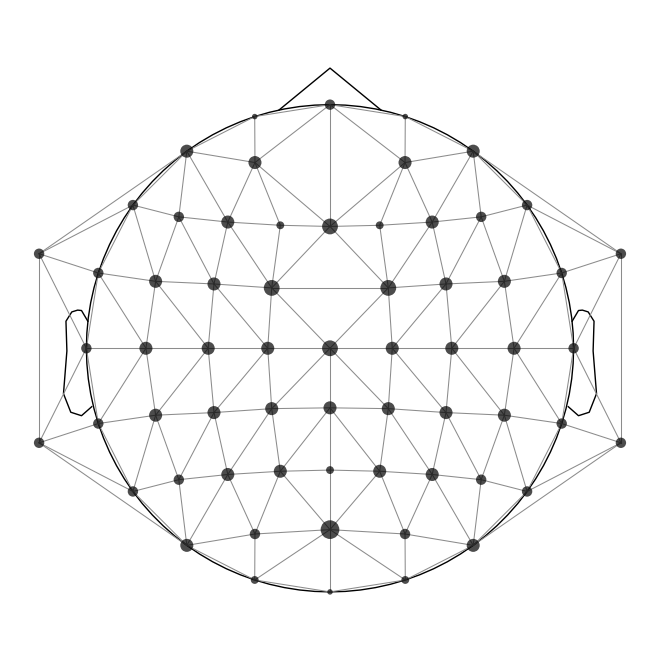

In [44]:
adjacency, ch_names = find_ch_adjacency(all2s_evoked[0][1].info, ch_type="eeg")
mne.viz.plot_ch_adjacency(all2s_evoked[0][1].info, adjacency, ch_names)
plt.show()

In [45]:
# our data at each observation is of shape frequencies × times × channels
tfr_adjacency = combine_adjacency(len(freqs), len(this_tfr.times), adjacency)

In [76]:
# This time we don't calculate a threshold based on the F distribution.
# We might as well select an arbitrary threshold for cluster forming
tfr_threshold = 20
# threshold_tfce = dict(start=12, step=1)

# run cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    # threshold=threshold_tfce,
    threshold = tfr_threshold,
    tail=1,
    n_jobs=8,
    buffer_size=None,
    # adjacency=tfr_adjacency,
    adjacency=None,
    seed=12345
)

stat_fun(H1): min=0.000000 max=25.346847
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [51]:
all2s_evoked[0][7]

<Evoked | 'Comment/60' (average, N=28), -0.2 – 0.5 s, baseline -0.2 – 0 s, 63 ch, ~439 kB>

[0.023 0.037 0.009 0.093 0.113 0.067 0.092]
[0 1 2 3 5 6]


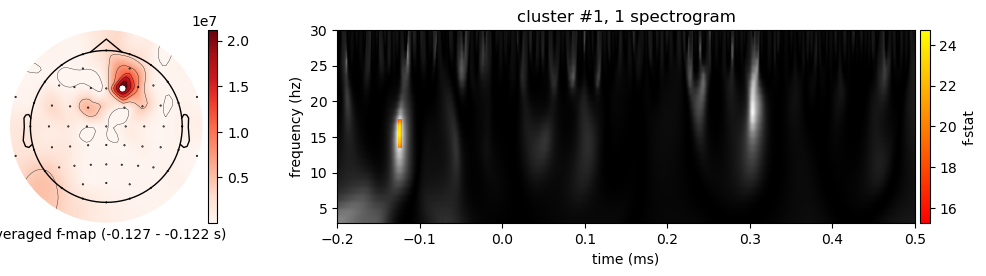

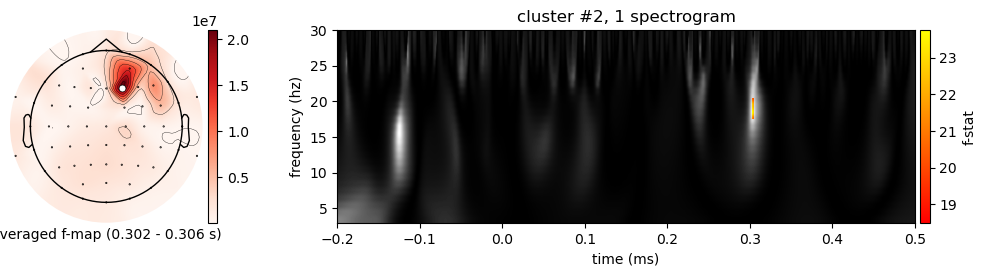

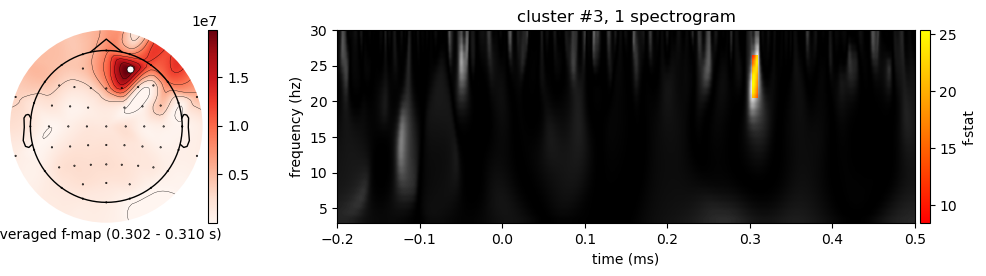

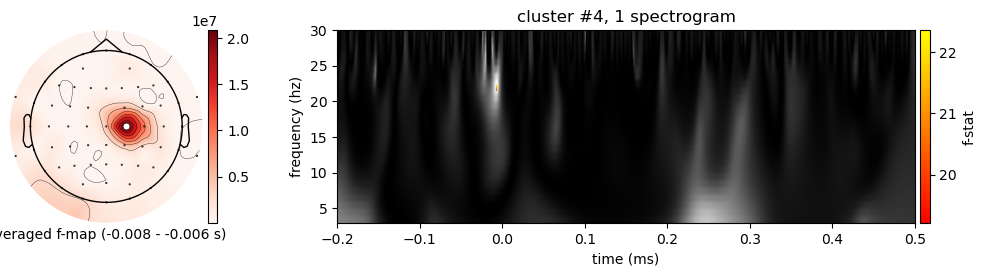

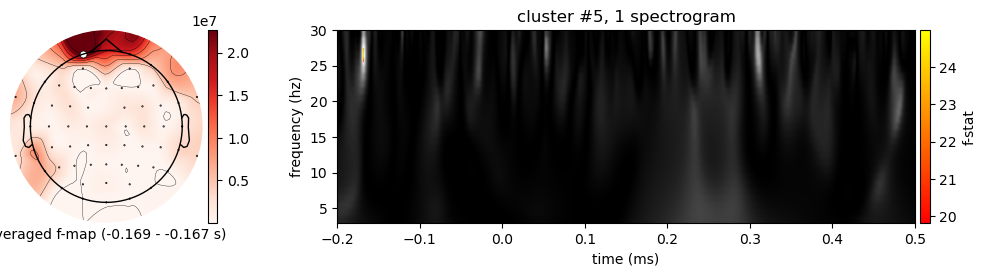

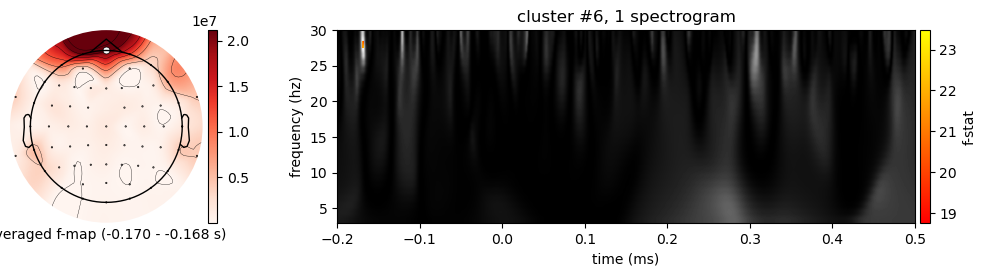

In [77]:
p_accept = 0.1

F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

print(p_values)
print(good_cluster_inds)

# sys.exit('pause')

for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    freq_inds, time_inds, space_inds = clusters[clu_idx]
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    freq_inds = np.unique(freq_inds)

    # get topography for f stat
    f_map = F_obs[freq_inds].mean(axis=0)
    f_map = f_map[time_inds].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = all2s_evoked[0][7].times[time_inds]

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], all2s_evoked[0][7].info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        # cmap="reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # create additional axes (for erf and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "averaged f-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # add new axis for spectrogram
    ax_spec = divider.append_axes("right", size="300%", pad=1.2)
    title = "cluster #{0}, {1} spectrogram".format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += " (max over channels)"
    f_obs_plot = F_obs[..., ch_inds].max(axis=-1)
    f_obs_plot_sig = np.zeros(f_obs_plot.shape) * np.nan
    f_obs_plot_sig[tuple(np.meshgrid(freq_inds, time_inds))] = f_obs_plot[
        tuple(np.meshgrid(freq_inds, time_inds))
    ]

    for f_image, cmap in zip([f_obs_plot, f_obs_plot_sig], ["gray", "autumn"]):
        c = ax_spec.imshow(
            f_image,
            cmap=cmap,
            aspect="auto",
            origin="lower",
            extent=[all2s_evoked[0][7].times[0], all2s_evoked[0][7].times[-1], freqs[0], freqs[-1]],
        )
    ax_spec.set_xlabel("time (ms)")
    ax_spec.set_ylabel("frequency (hz)")
    ax_spec.set_title(title)

    # add another colorbar
    ax_colorbar2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(c, cax=ax_colorbar2)
    ax_colorbar2.set_ylabel("f-stat")

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=0.05)

plt.show()